# Цель работы

У нас в распоряжении есть данные по продажам с 2012 по 2015 год

Наша задача составить общую картину финансового положения магазина, проанализировав его основные метрики + дать рекомендации по дальнейшему развитию

## Содержание:
1. [Предобработка данных](#1)
1. [EDA](#2)
    1. [Общие тенденции](#2_1)
    1. [Основные показатели](#2_2)
1. [Когортный анализ](#3)
    1. [Retention](#3_1)
    1. [LTV](#3_2)
1. [RFM](#3)
1. [Результаты](#4)


# 1. Предобработка данных <a class="anchor" id="1"></a>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt
import squarify

In [30]:
df = pd.read_csv("superstore.csv")

In [31]:
df.head(3)

,Unnamed: 0,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Delivery Days,order year,order month
0,0,CA-2014-AB10015140-41954,11-11-2014,13-11-2014,First Class,AB-100151402,Aaron Bergman,Consumer,Oklahoma City,Oklahoma,...,Samsung Convoy 3,221,2,0.0,62,40,High,2,2014,11
1,1,IN-2014-JR162107-41675,05-02-2014,07-02-2014,Second Class,JR-162107,Justin Ritter,Corporate,Wollongong,New South Wales,...,"Novimex Executive Leather Armchair, Black",3709,9,0.1,-288,923,Critical,2,2014,2
2,2,IN-2014-CR127307-41929,17-10-2014,18-10-2014,First Class,CR-127307,Craig Reiter,Consumer,Brisbane,Queensland,...,"Nokia Smart Phone, with Caller ID",5175,9,0.1,919,915,Medium,1,2014,10


In [32]:
df.shape

(51290, 26)

In [33]:
df.columns

Index(['Unnamed: 0', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Region', 'Market', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping Cost', 'Order Priority', 'Delivery Days', 'order year',
       'order month'],
      dtype='object')

Удалим ненужные столбцы

In [34]:
df.drop(columns = ['Unnamed: 0', 'Customer Name', 'Product ID'], inplace = True)

Посмотрим есть ли пропуски

In [35]:
df.isna().sum()

Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Segment           0
City              0
State             0
Country           0
Region            0
Market            0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping Cost     0
Order Priority    0
Delivery Days     0
order year        0
order month       0
dtype: int64

## Дубликаты

In [36]:
df[df.duplicated()]

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Country,Region,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Delivery Days,order year,order month
36524,ES-2014-SR20740120-41804,14-06-2014,21-06-2014,Standard Class,SR-20740120,Home Office,Madrid,Madrid,Spain,Southern Europe,...,"Wilson Jones 3-Hole Punch, Economy",83,3,0.0,27,3,Medium,7,2014,6
39293,KE-2014-PC900069-41693,23-02-2014,25-02-2014,Second Class,PC-900069,Home Office,Thika,Central,Kenya,Eastern Africa,...,"Cameo Business Envelopes, Set of 50",20,1,0.0,8,2,High,2,2014,2
45322,ID-2012-AR105107-41031,02-05-2012,08-05-2012,Standard Class,AR-105107,Consumer,Armidale,New South Wales,Australia,Oceania,...,"Cardinal Hole Reinforcements, Recycled",15,3,0.1,2,1,Medium,6,2012,5


In [37]:
df.drop_duplicates(inplace=True)

Посмотрим на типы данных

In [38]:
df.dtypes

Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Segment            object
City               object
State              object
Country            object
Region             object
Market             object
Category           object
Sub-Category       object
Product Name       object
Sales               int64
Quantity            int64
Discount          float64
Profit              int64
Shipping Cost       int64
Order Priority     object
Delivery Days       int64
order year          int64
order month         int64
dtype: object

In [39]:
df['Order Date'] = pd.to_datetime(df['Order Date'],dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'],dayfirst=True)

In [40]:
df.dtypes

Order ID                  object
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Ship Mode                 object
Customer ID               object
Segment                   object
City                      object
State                     object
Country                   object
Region                    object
Market                    object
Category                  object
Sub-Category              object
Product Name              object
Sales                      int64
Quantity                   int64
Discount                 float64
Profit                     int64
Shipping Cost              int64
Order Priority            object
Delivery Days              int64
order year                 int64
order month                int64
dtype: object

# 2. EDA <a class="anchor" id="2"></a>

## Общие тенденции <a class="anchor" id="2_1"></a>

In [42]:
df.head(3)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Country,Region,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Delivery Days,order year,order month
0,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Consumer,Oklahoma City,Oklahoma,United States,Central US,...,Samsung Convoy 3,221,2,0.0,62,40,High,2,2014,11
1,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Corporate,Wollongong,New South Wales,Australia,Oceania,...,"Novimex Executive Leather Armchair, Black",3709,9,0.1,-288,923,Critical,2,2014,2
2,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Consumer,Brisbane,Queensland,Australia,Oceania,...,"Nokia Smart Phone, with Caller ID",5175,9,0.1,919,915,Medium,1,2014,10


Посчитаем обьем выручки по сегментам

<AxesSubplot:xlabel='Segment', ylabel='Sales'>

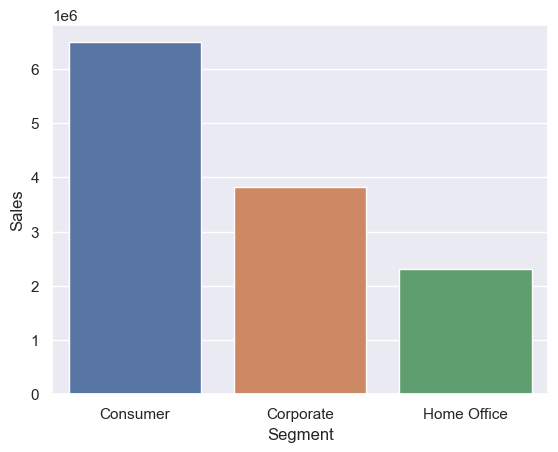

In [43]:
sns.set_theme()
rev_seg = df.groupby('Segment', as_index=False).sum('Sales')
sns.barplot(x = 'Segment', y = 'Sales', data = rev_seg)

Магазин больше ориентируется на потребительский рынок <br>
Посмотрим на это в разрезе по городам

<AxesSubplot:xlabel='City', ylabel='Sales'>

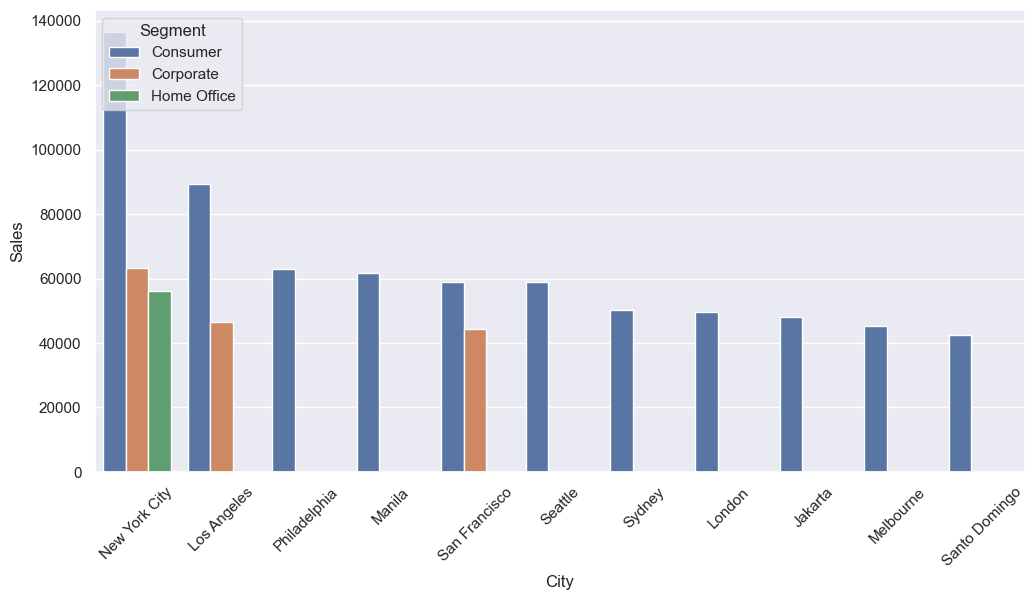

In [44]:
sns.set(rc = {'figure.figsize':(12, 6)})
plt.xticks(rotation=45)
rev_city = df.groupby(['City','Segment'], as_index=False).sum('Sales').nlargest(15,columns='Sales')
sns.barplot(x = 'City', y = 'Sales', hue = 'Segment', data = rev_city)


На первых местах города США, но дальше идет много городов Океании. Посмотрим на графике как распределеная выручка по регионам

<AxesSubplot:xlabel='Market', ylabel='Sales'>

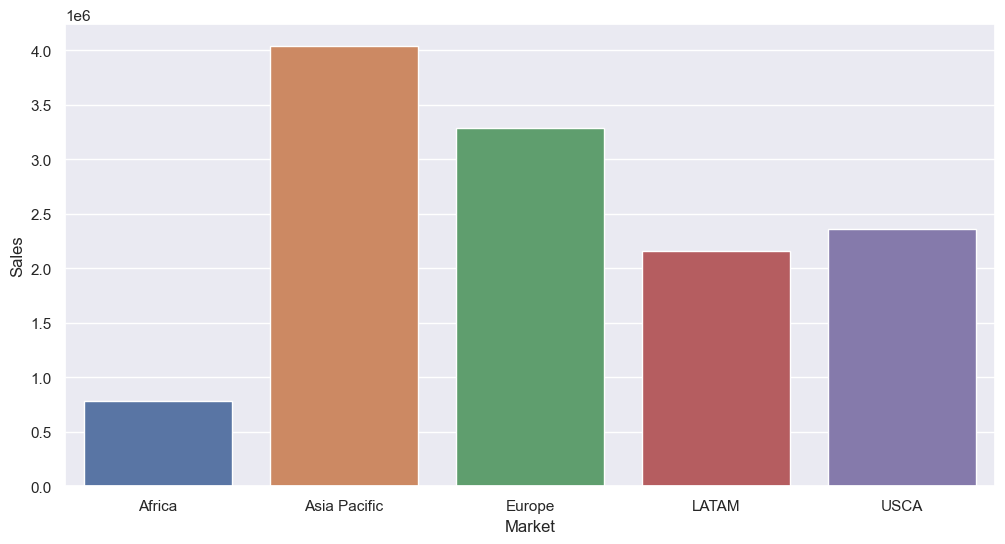

In [45]:
markets = df.groupby('Market', as_index=False).sum('Sales')
sns.barplot(x = 'Market', y = 'Sales', data = markets)

Интересно, значительную часть выручки магазин получает из Азиатско-Тихоакеанского региона.

<AxesSubplot:xlabel='Market', ylabel='Sales'>

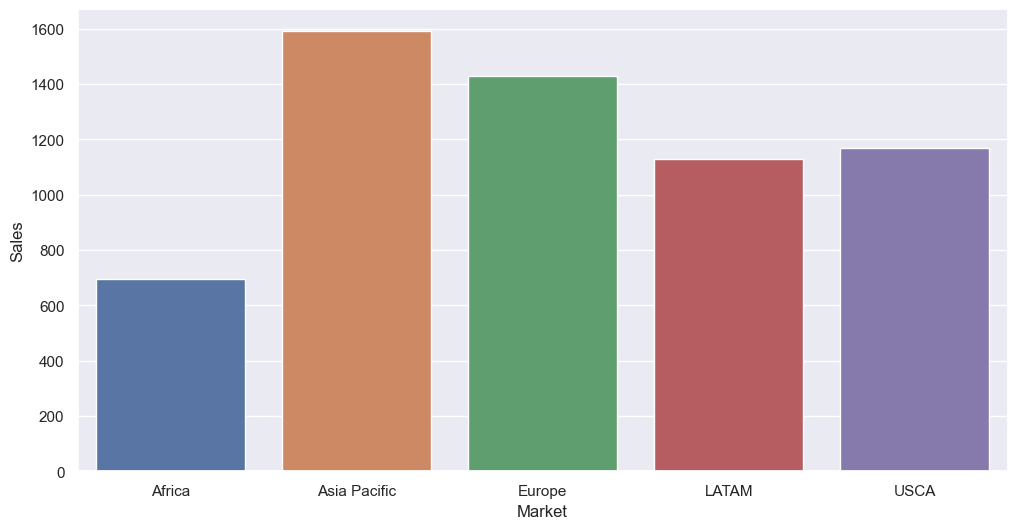

In [46]:
markets = df.groupby('Market', as_index=False).nunique('customer_id')
sns.barplot(x = 'Market', y = 'Sales', data = markets)

<AxesSubplot:xlabel='Country', ylabel='Sales'>

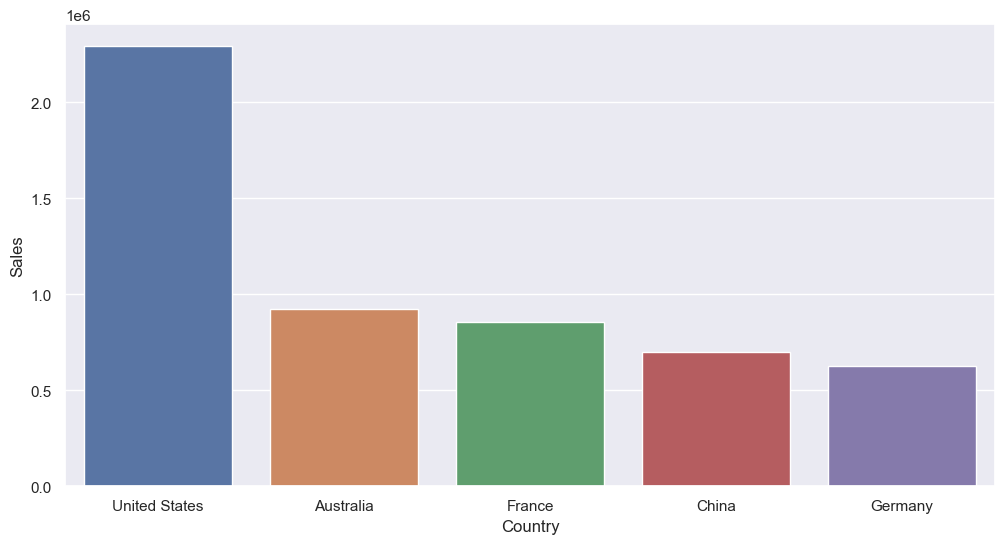

In [47]:
markets = df.groupby('Country', as_index=False).sum('Sales').nlargest(5,'Sales')
sns.barplot(x = 'Country', y = 'Sales', data = markets)

При группировке по странам на первом месте с большим отрывом штаты. 

Теперь посчитаем скорость доставки в зависимости от типа

<AxesSubplot:xlabel='Ship Mode', ylabel='Delivery Days'>

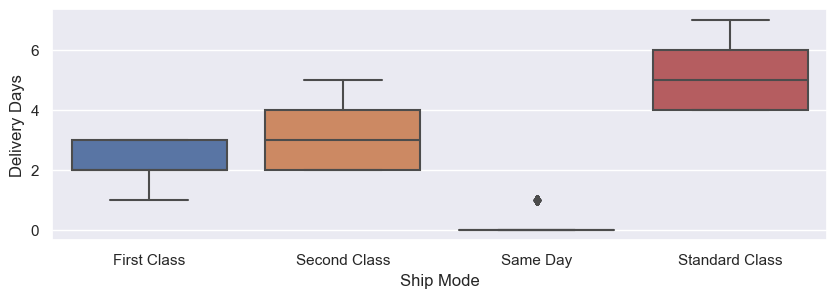

In [48]:
sns.set(rc = {'figure.figsize':(10, 3)})

sns.boxplot(x = 'Ship Mode', y = 'Delivery Days', data = df)


Видно, что все примерно соответствует названиям

Теперь перейдем к категориям

<AxesSubplot:xlabel='Category', ylabel='Sales'>

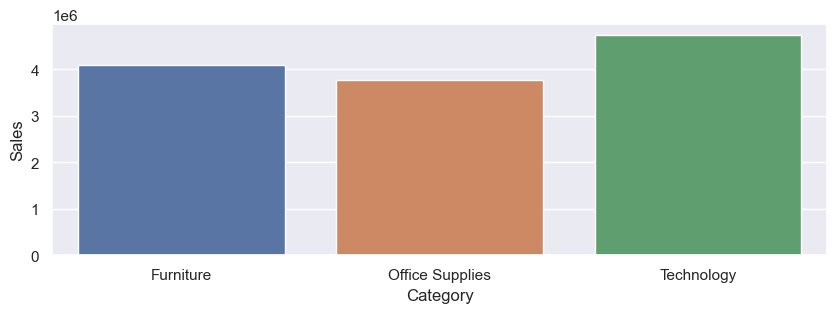

In [49]:
sns.barplot(x = 'Category',y='Sales',
    data=df.groupby('Category',as_index=False)['Sales'].sum())

<AxesSubplot:xlabel='Sales', ylabel='Sub-Category'>

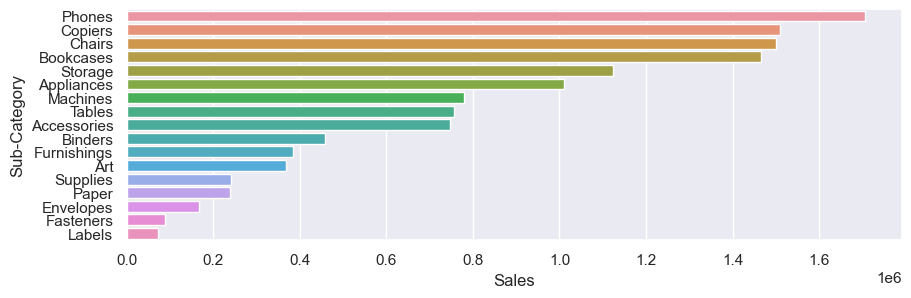

In [50]:
sns.barplot(x = 'Sales',y='Sub-Category',
    data=df.groupby('Sub-Category',
                    as_index=False)['Sales'].sum().sort_values(by='Sales', ascending=False), orient='h')

По выручке с открывом побеждают телефоны

## Основные показатели <a class="anchor" id="2_2"></a>

In [51]:
df = df.sort_values(by='Order Date') # отсортируем данные по датам

In [52]:
# сделаем основные временные промежутки группировки
df['date_month'] = df['Order Date'].dt.to_period('M').astype('datetime64')
df['date_year'] = df['Order Date'].dt.to_period('Y')
df['date_week'] = df['Order Date'].dt.to_period('W')

Сгруппируем выручку, прибыль, количество заказов и клиентов по годам

In [53]:
years = df.groupby('date_year',
                    as_index=False).agg({'Sales':'sum','Profit':'sum',
                                                               'Order ID':'nunique','Customer ID':'nunique'})

Рассчитаем дополнительно средний чек и количество заказов на клиента

In [54]:
years.columns = ['date_year','Sales','Profit', 'Orders','Clients']
years['Ord_per_client'] = round(years['Orders']/years['Clients'],2)
years['Check'] = round(years['Sales']/years['Orders'],2)


In [55]:
years.head()

,date_year,Sales,Profit,Orders,Clients,Ord_per_client,Check
0,2012,2254748,246688,4515,4164,1.08,499.39
1,2013,2671783,304664,5473,4949,1.11,488.18
2,2014,3398568,403408,6883,6113,1.13,493.76
3,2015,4290805,499839,8857,7624,1.16,484.45


Посмотрим на динамику показателей по годам

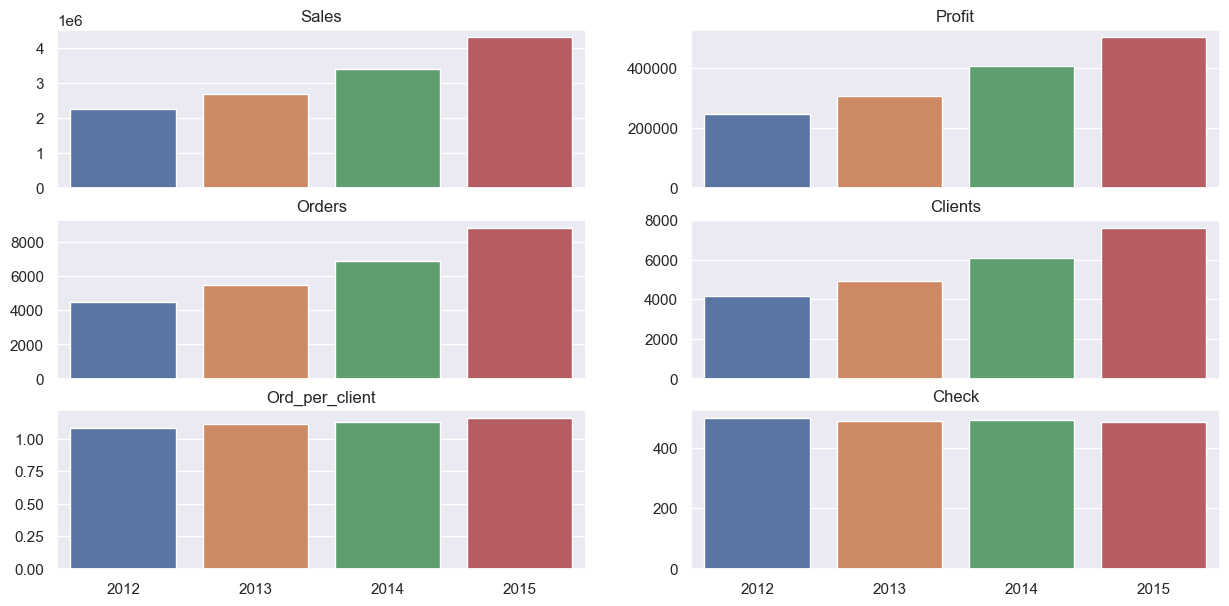

In [59]:
fig, ax = plt.subplots(3,2,figsize = (15,7), sharex=True) # делаем общий график
y, x = 0, 0 # указываем координаты каждого графика

for i in years.columns[1:]:
    
    sns.barplot(x='date_year',y = i, data = years, ax = ax[y][x])
    ax[y][x].set_xlabel(None) # убираем подписи осей
    ax[y][x].set_ylabel(None)
    ax[y][x].set_title(i) # делаем имя
    x+=1
    if x == 2:
        y+=1
        x = 0



Тенденция хорошая. Вынесем показатели за последний год в виде текста

In [60]:
def bold(text):
    return '\033[1m' + str(text) + '\033[0m'

a = list(years.iloc[-2:,:].values)
print(f'Общие показатели {a[1][0]} года:')
perc = []
for i in range(1,7):
    perc.append(bold(round((a[1][i]/a[0][i]-1)*100,2)))


print(f'Выручка - {bold(a[1][1])}, прирост отностельно прошлого года {perc[0]}%')
print(f'Прибыль - {bold(a[1][2])}, прирост отностельно прошлого года {perc[1]}%')
print(f'Количество заказов - {bold(a[1][3])}, прирост отностельно прошлого года {perc[2]}%')
print(f'Уникальных клиентов - {bold(a[1][4])}, прирост отностельно прошлого года {perc[3]}%')
print(f'Количество заказов на человека - {bold(a[1][5])}, прирост отностельно прошлого года {perc[4]}%')
print(f'Средний чек - {bold(a[1][6])}, прирост отностельно прошлого года {perc[5]}%')


Общие показатели 2015 года:
Выручка - 4290805, прирост отностельно прошлого года 26.25%
Прибыль - 499839, прирост отностельно прошлого года 23.9%
Количество заказов - 8857, прирост отностельно прошлого года 28.68%
Уникальных клиентов - 7624, прирост отностельно прошлого года 24.72%
Количество заказов на человека - 1.16, прирост отностельно прошлого года 2.65%
Средний чек - 484.45, прирост отностельно прошлого года -1.89%


Из примечательного, больше одного заказа за год практически не заказывают

In [61]:
months = df.groupby(['date_year','date_month'], as_index=False ).agg({'Sales':'sum','Profit':'sum','Order ID':'nunique','Customer ID':'nunique'})

In [62]:
months.columns = ['date_year','date_month','Sales','Profit', 'Orders','Clients']

In [63]:
months['Ord_per_client'] = round(months['Orders']/months['Clients'],2)
months['mean_check'] = round(months.Sales/months.Orders)

In [ ]:
months.head(3)

,date_year,date_month,Sales,Profit,Orders,Clients,Ord_per_client,mean_check
0,2012,2012-01-01,98666,8224,216,215,1.0,457.0
1,2012,2012-02-01,103493,14216,203,202,1.0,510.0
2,2012,2012-03-01,135475,12952,266,266,1.0,509.0


In [64]:
means = months.groupby('date_year',as_index=False).mean().round(2)

In [ ]:
means.head()

,date_year,Sales,Profit,Orders,Clients,Ord_per_client,mean_check
0,2012,187896.92,20557.50,376.25,373.50,1.01,492.50
1,2013,222648.58,25388.67,456.08,451.50,1.01,487.58
2,2014,283222.58,33620.25,573.58,568.08,1.01,499.17
3,2015,357567.08,41653.25,738.08,727.75,1.01,485.08


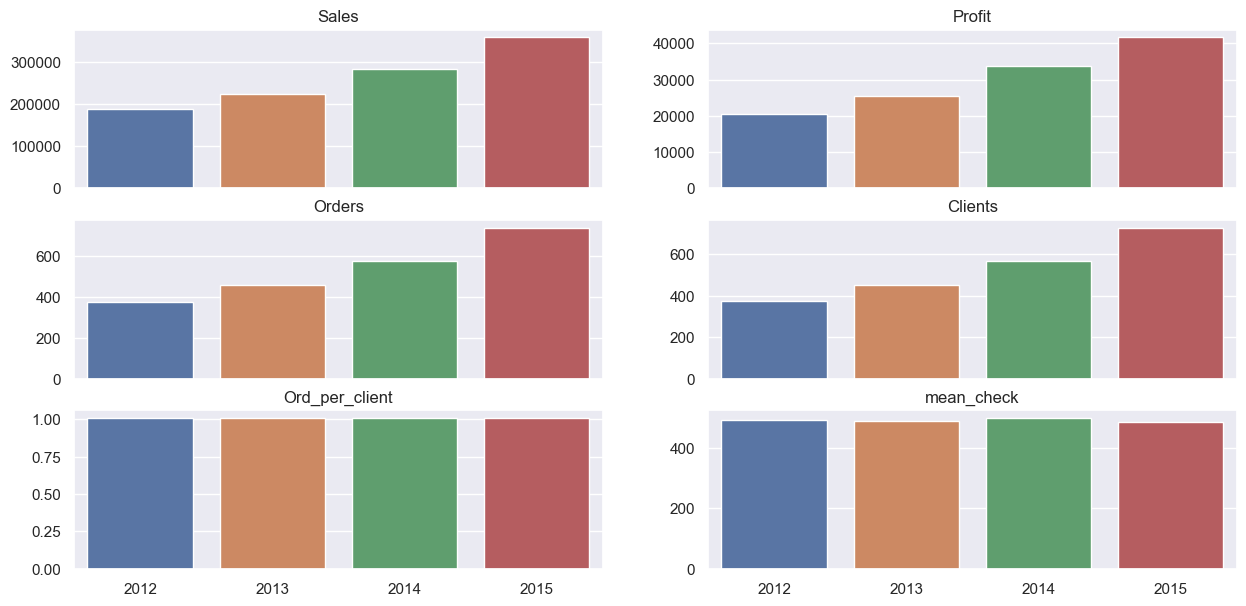

In [65]:
fig, ax = plt.subplots(3,2,figsize = (15,7), sharex=True)
y = 0
x = 0
for i in means.columns[1:]:
    
    sns.barplot(x='date_year',y = i, data = means, ax = ax[y][x])
    ax[y][x].set_xlabel(None)
    ax[y][x].set_ylabel(None)
    ax[y][x].set_title(i)
    x+=1
    if x == 2:
        y+=1
        x = 0

In [66]:
a = list(means.iloc[-2:,:].values)
print(f'Месячные показатели за 2015 год:')
print(f'Среднее обьем выручки за месяц - {bold(a[1][1])}')
print(f'Средняя прибыль за месяц - {bold(a[1][2])}')
print(f'Среднее количество заказов за месяц - {bold(a[1][3])}')
print(f'Среднее количество клиентов за месяц - {bold(a[1][4])}')
print(f'Средний количество заказов на одного клиента - {bold(a[1][5])}')
print(f'Средний чек за месяц - {bold(a[1][6])}')


Месячные показатели за 2015 год:
Среднее обьем выручки за месяц - 357567.08
Средняя прибыль за месяц - 41653.25
Среднее количество заказов за месяц - 738.08
Среднее количество клиентов за месяц - 727.75
Средний количество заказов на одного клиента - 1.01
Средний чек за месяц - 485.08


Построим линейные графики

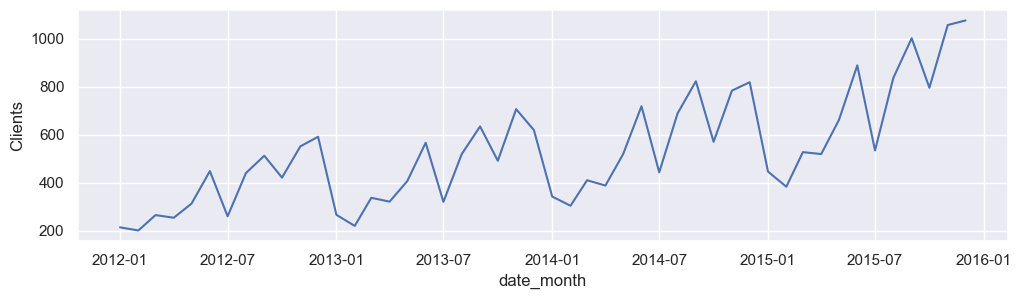

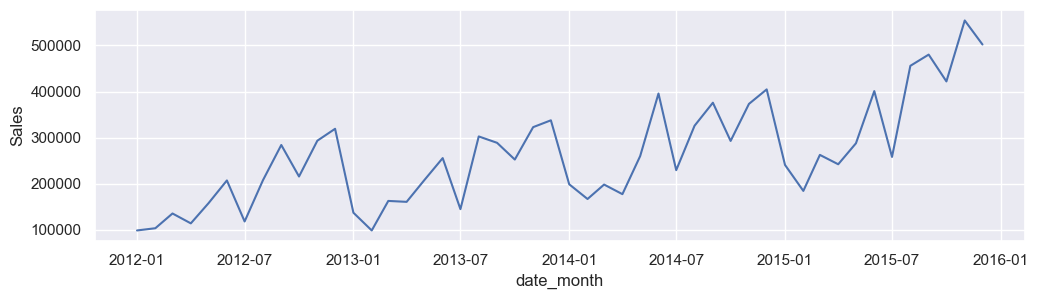

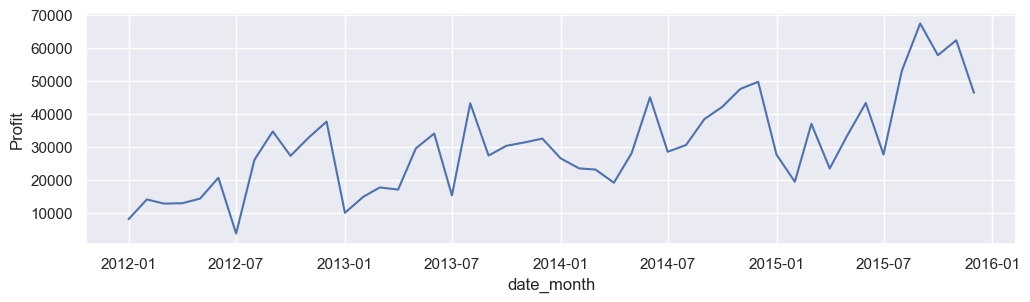

In [67]:
sns.set(rc = {'figure.figsize':(12, 3)})
sns.lineplot(x ='date_month', y = 'Clients', data = months)
plt.show()
sns.set(rc = {'figure.figsize':(12, 3)})
sns.lineplot(x ='date_month', y = 'Sales', data = months)
plt.show()
sns.set(rc = {'figure.figsize':(12, 3)})
sns.lineplot(x ='date_month', y = 'Profit', data = months)
plt.show()

> У продаж и количества клиентов присутствует явная сезонность

Чтобы проверить это сравним на одном графике два последних года

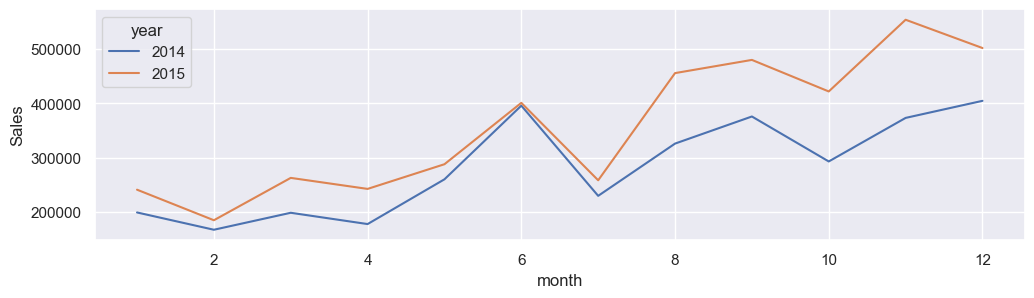

In [ ]:
months['year'] = months['date_month'].dt.year
months['month'] = months['date_month'].dt.month
sns.set(rc = {'figure.figsize':(12, 3)})
compare = months.query('date_month>"2013-12"')[['Sales','year','month']]
sns.lineplot(data = compare, x = 'month', y = 'Sales', hue = 'year', palette=["C0", "C1"]) 
plt.show()


>Действиетльно,  у нас низкие продажи в начале года, но они постепенно растут, также спад продаж происходит в июле

<AxesSubplot:xlabel='date_month', ylabel='mean_check'>

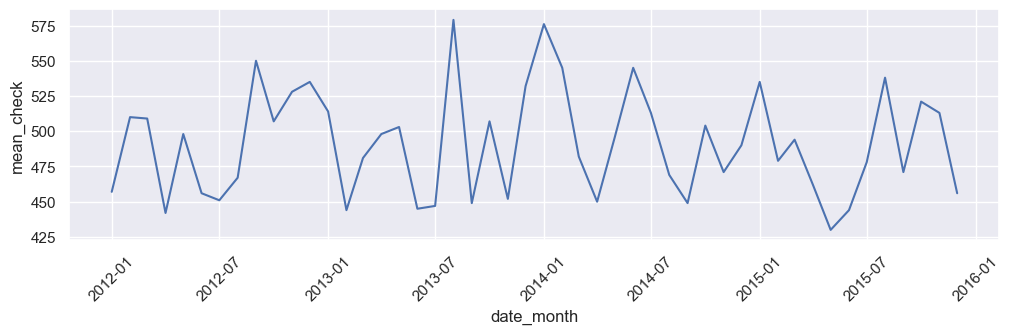

In [ ]:
plt.xticks(rotation = 45)
sns.set(rc = {'figure.figsize':(15, 10)})
sns.lineplot(x = months.date_month, y = months['mean_check'])

> Явно выраженной сезонности не заметно

# 3. Когортный анализ <a class="anchor" id="3"></a>

Разделим наших пользователей на группы по дате первой  покупки и посчитаем по ним Retention и LTV

## Retention <a class="anchor" id="3_1"></a>

Но сначала посмотрим на общую картину

In [68]:
ret = df.groupby('Customer ID',as_index=False).agg({'Order ID':'nunique'})
gen_retention = ret[ret['Order ID']>1]['Customer ID'].count()/ret['Customer ID'].count()*100


In [69]:
print(f'{round(gen_retention,2)}% пользователей совершает более одной покупки')

31.21% пользователей совершает более одной покупки


Есть к чему стремится. Посчитаем как этот показатель ведет себя в динамике по годам

In [70]:
first_sales= df.groupby('Customer ID',as_index=False).agg({'date_week':'min','date_month':'min', 'date_year':'min'}) # считаем первую неделю, месяц и год покупки
first_sales.columns = ['Customer ID','first_sale_week', 'first_sale_month','first_sale_year'] # переименовываем столбцы
df = df.merge(first_sales,on='Customer ID') # соединяем с основной таблицей

In [71]:
gen_retention_years = df.groupby(['first_sale_year','Customer ID'],as_index=False)['Order ID'].nunique() # группируем по первому году и айдишнику, считаем количество заказов

gen_retention_years['Retention'] = gen_retention_years['Order ID']>1

gen_retention_years.groupby('first_sale_year').agg({'Retention': lambda x: round(x.sum()/x.count()*100,2), # считаем процент тех, кто заказывал болше 1-го раза
                                                    'Customer ID':'nunique'})

,Retention,Customer ID
first_sale_year,,
2012,49.90,4164
2013,40.20,4197
2014,27.40,4419
2015,9.92,4635


> Тут уже интереснее. Показатель со временем убывает, что логично, так как для более молодых пользователей еще не прошло достаточное количество времени. <br> 

Теперь посчитаем возвращаемость для каждого года более подробно

In [72]:
retention = df.pivot_table( # делаем сводную таблицу где строчки это первый год покупки, а столцы года покупок в общем
    index = 'first_sale_year',
    columns='date_year',
    values= 'Customer ID', # В качестве значений берем количество уникальных пользователей
    aggfunc = 'nunique'
)

Построим для визуализации тепловую карту

<AxesSubplot:xlabel='date_year', ylabel='first_sale_year'>

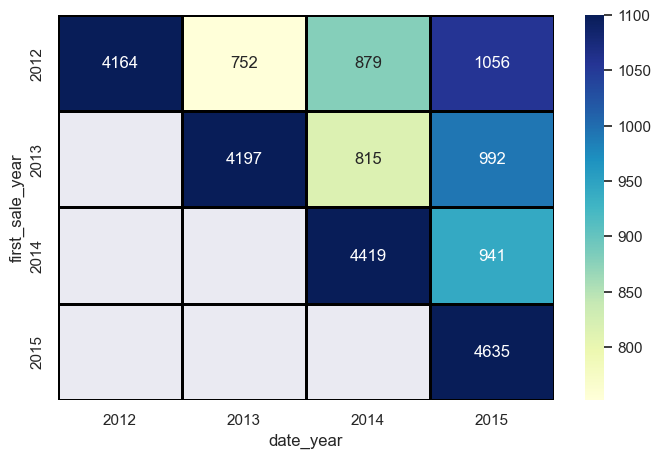

In [73]:
sns.set(rc = {'figure.figsize':(8, 5)})
sns.heatmap(
    retention,
    annot=True,
    fmt='.0f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu",
    vmax = 1100
)

Для удобства перевем все в проценты

<AxesSubplot:xlabel='date_year', ylabel='first_sale_year'>

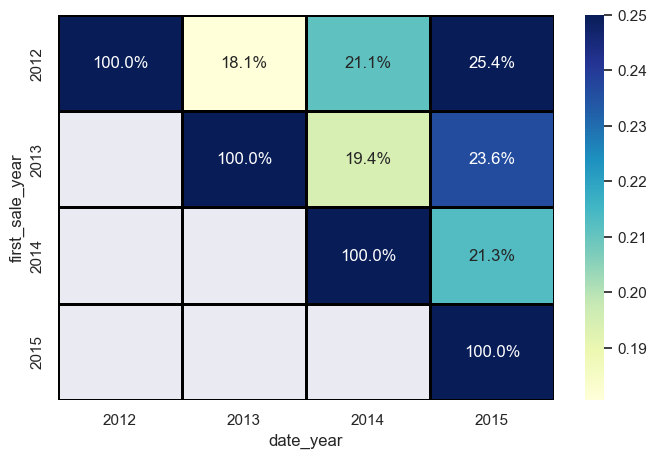

In [75]:
rows = retention.values.diagonal() # берем количество новых пользователей за каждый год

for s,row in zip(rows, retention): 
    retention.loc[row] = retention.loc[row]/s # проходимся по каждой строчке и нормируем на изначаальное количество пользователей в этой когорте
    sns.set(rc = {'figure.figsize':(8, 5)})
    
sns.heatmap(
    retention,
    annot=True,
    fmt='.1%',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu",
    vmax=0.25
)

> Видны положительные тенденции. Ретеншн следующего года в более новых когортах выше, плюс в каждой когорте по отдельности ретеншн постепенно возрастает

Посмотрим как обстоят тела в разрезе по сегментам

In [77]:
retention_years = df.pivot_table(
    index = ['first_sale_year','Segment'], # группируем по году и сегменту
    columns='date_year',
    values= 'Customer ID',
    aggfunc = 'nunique'
)

<AxesSubplot:xlabel='date_year', ylabel='first_sale_year-Segment'>

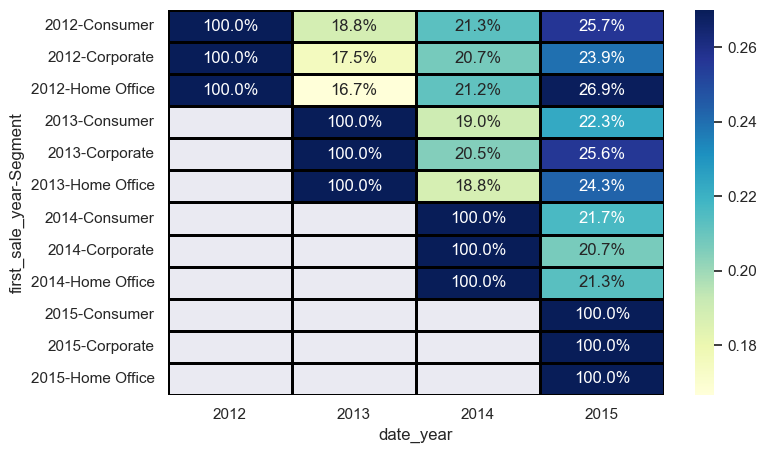

In [78]:
row = 0
indx = np.array([])
for col in range(4):
    indx = np.concatenate((indx,retention_years.values[row:(row+3),col:(col+1)].flatten()), axis=0) # получаем значения первого года за каждый сектор
    row+=3


for s,row in zip(indx, range(12)):
    retention_years.iloc[row] = (retention_years.iloc[row]/s) # нормируем это все

sns.set(rc = {'figure.figsize':(8, 5)})
sns.heatmap( # строим график
    retention_years,
    annot=True,
    fmt='.1%',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu",
    vmax=0.27
)

Тут в целов тенденции аналогичные. Теперь посчитаем LTV

## LTV <a class="anchor" id="3_2"></a>

Чтобы найти LTV нужно сначала посчитать прибыль за каждый год и количество уникальных ползователей, этим и займемся

In [81]:
ltv_by_years = df.groupby(['first_sale_year','date_year'], as_index=False).agg({'Profit':'sum', # группируем данные по когортам и годам покупок
                                                  'Customer ID':'nunique'})    
                                                     
ltv_by_years['ltv'] = ltv_by_years['Profit']/ltv_by_years['Customer ID'] # считаем LTV по формуле

Создадим сводную таблицу и визуализацию для полученных значений

<AxesSubplot:xlabel='date_year', ylabel='first_sale_year'>

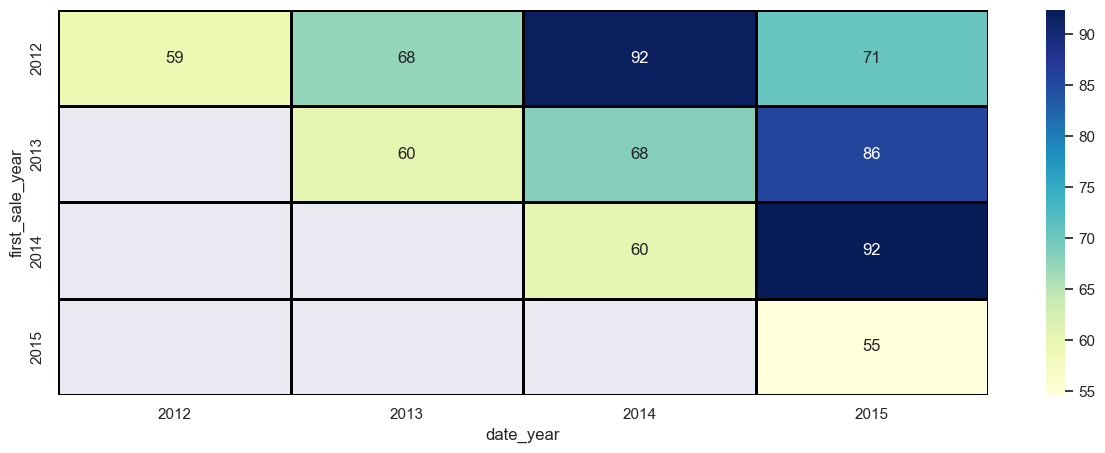

In [83]:
pivot = ltv_by_years.pivot_table( 
    index = 'first_sale_year',
    columns='date_year', # в строках когорты, в столбцах года покупок
    values= 'ltv' # агрегация не понадобилась, росто выводим значения
)

sns.set(rc = {'figure.figsize':(15, 5)})
sns.heatmap(
    pivot,
    annot=True,
    fmt='.0f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
)

 > LTV первого года стоит на месте, неприятно. Видно, что LTV сильно возрастает через один год после покупки, возможно клиенты решают обновить телефоны/другую технику

Теперь нормируем эти показатели на retention

In [86]:
pivot_ltv = retention*pivot


<AxesSubplot:xlabel='date_year', ylabel='first_sale_year'>

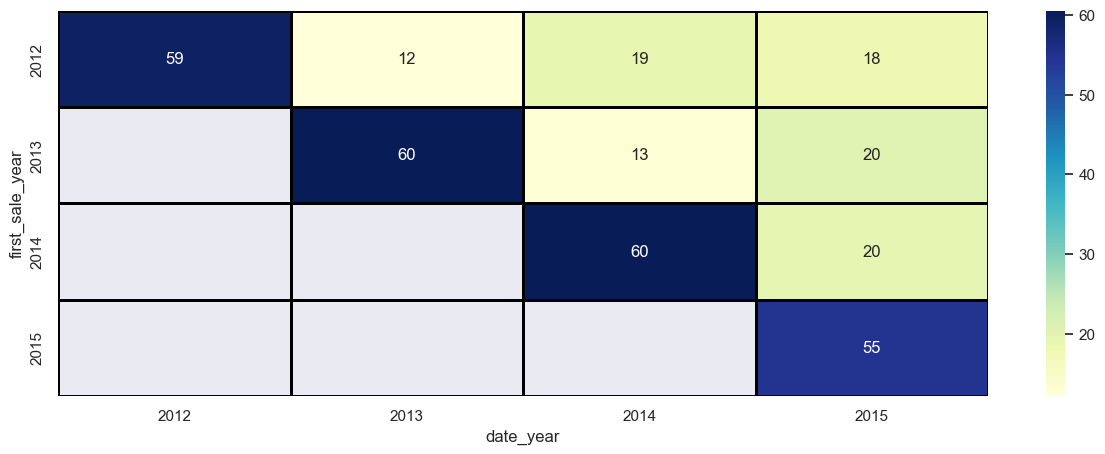

In [87]:
sns.set(rc = {'figure.figsize':(15, 5)})
sns.heatmap(
    pivot_ltv,
    annot=True,
    fmt='.0f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
)

Из приятного, видно что LTV следующего года постепенно растет. <br>
Чтобы посчитать полное LTV для каждой когорты осталось вычислить кумулятивную сумму этих значений

<AxesSubplot:xlabel='date_year', ylabel='first_sale_year'>

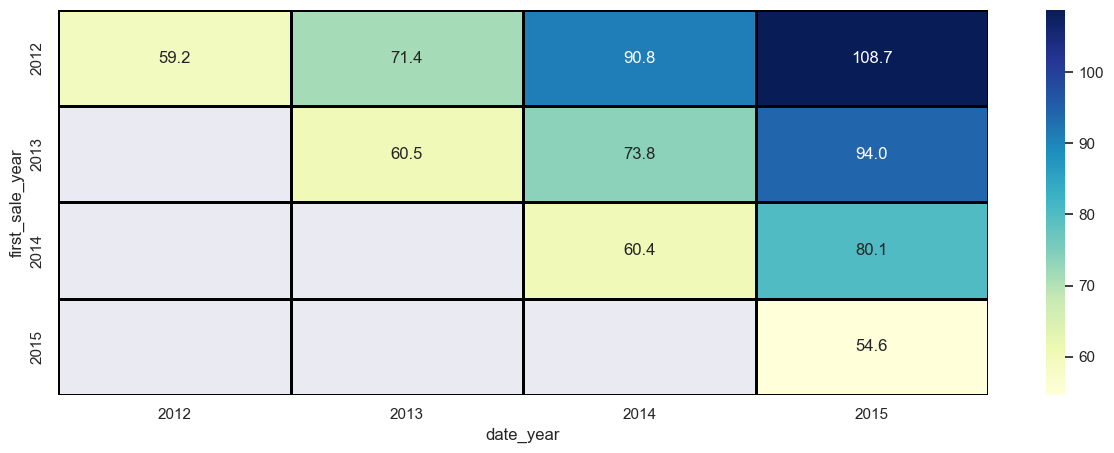

In [89]:
final_ltv = pivot_ltv.cumsum(axis=1)
sns.set(rc = {'figure.figsize':(15, 5)})
sns.heatmap(
    final_ltv,
    annot=True,
    fmt='.1f',
    linewidths=1, 
    linecolor='black', 
    cmap="YlGnBu"
)

Теперь у нас есть LTV для каждой отдельной когорты. Проверим насколько правильно мы его посчитали

In [113]:
gen_ltv = df.groupby('first_sale_year').agg({'Profit':'sum','Customer ID':'nunique'})   
gen_ltv['ltv'] = round(gen_ltv['Profit'] / gen_ltv['Customer ID'],2)
gen_ltv['ltv']

first_sale_year
2012    108.73
2013     94.03
2014     80.10
2015     54.64
Freq: A-DEC, Name: ltv, dtype: float64

Отлично, все совпало

Попробуем разделить наших клиентов уже по другим показателям с помощью RFM аналза

# 4. RFM <a class="anchor" id="4"></a>

Сначала выберем нужные столбцы

In [120]:
rfm_df = df[['Customer ID','Order ID','Order Date','Sales']] 

Посчитаем нужные метрики для каждого клиента (как давно покупал, количество покупок, общая сумма)

In [121]:
now = rfm_df['Order Date'].max() # находим самую последнюю дату в данных
rfm = (
    rfm_df.groupby('Customer ID') 
    .agg({
        'Order Date': lambda date: (now - date.max()).days, # считаем количество дней с последней покупки 
        'Order ID': 'count',                                    # число заказов
        'Sales': 'sum'                                      # суммарные траты
    })
)

In [122]:
rfm.columns = ['recency', 'frequency', 'monetary'] # переименуем колонки

Посмотрим на гистограммы получившихся показателей

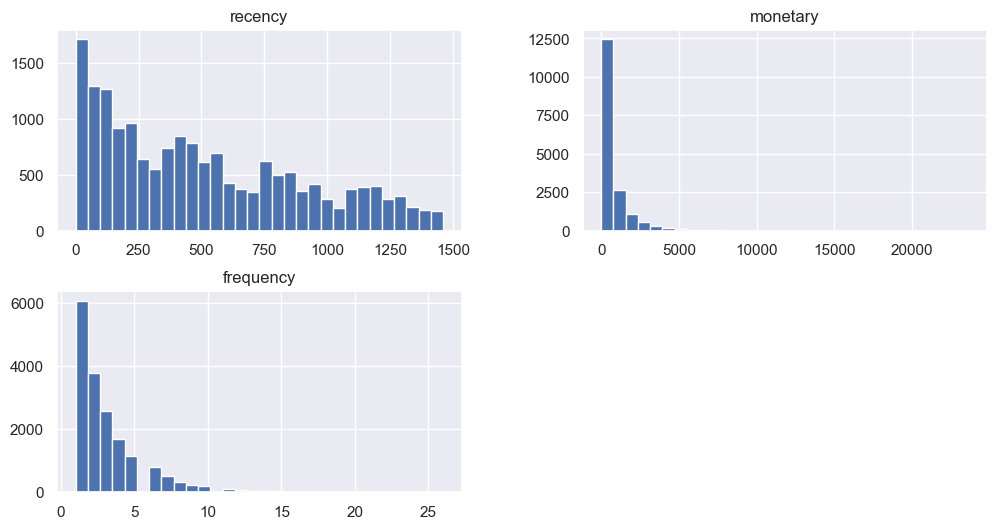

In [123]:
rfm[['recency', 'monetary', 'frequency']].hist(figsize=(12,6), bins=30);

Все распределения экспоненциальные, а у частоты и суммы покупок присутствуют большие выбросы

Проведем сегментацию по каждому параметру с помощью квантилей

In [125]:
rfm['r_quartile'] = pd.qcut(rfm['recency'].rank(method='first'), 4, labels = ['1','2','3','4']) # выбираем количество сегментов и метод ранжирования
rfm['f_quartile'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'].rank(method='first'), 4, labels = ['4','3','2','1'])

Совместим все полученные результаты в одну общую оценку

In [129]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str) + rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)

In [131]:
rfm['RFM_Score'].nunique()

64

У нас получилось 64 разных сегмента, но для более удобного анализа распределим их на схожие группы

In [133]:
def clasify(x):
    if x == '111': # Постоянные клиенты, покупают много и часто
        return "Лучшие"
    elif x[0] in '12' and x[1] in '12' and x[2] in '12': # чуть хуже первых, но тоже хорошие
        return 'Лояльные постоянные'
    elif x[0] in '34' and x[1] in '12' and x[2] in '12': # раньше много и часто покупали, но уже давно у нас не бывали
        return "Требуют внимания"
    elif x[0] in '12' and x[1] =='4': # Недавно сделали первую покупку
        return "Недавние"
    elif x[0] == '4' and (x[1]=='4' or x[2]=='4'): # уже давно небыли и почти ничего не заказывали, возвращать смысла мало
        return "Потерянные"
    else:                                        # все остальные
        return "Обычные"
   

In [134]:
rfm['group'] = rfm.RFM_Score.apply(clasify)

Сделаем наглядную визуализацию в виде древовидной карты

<AxesSubplot:>

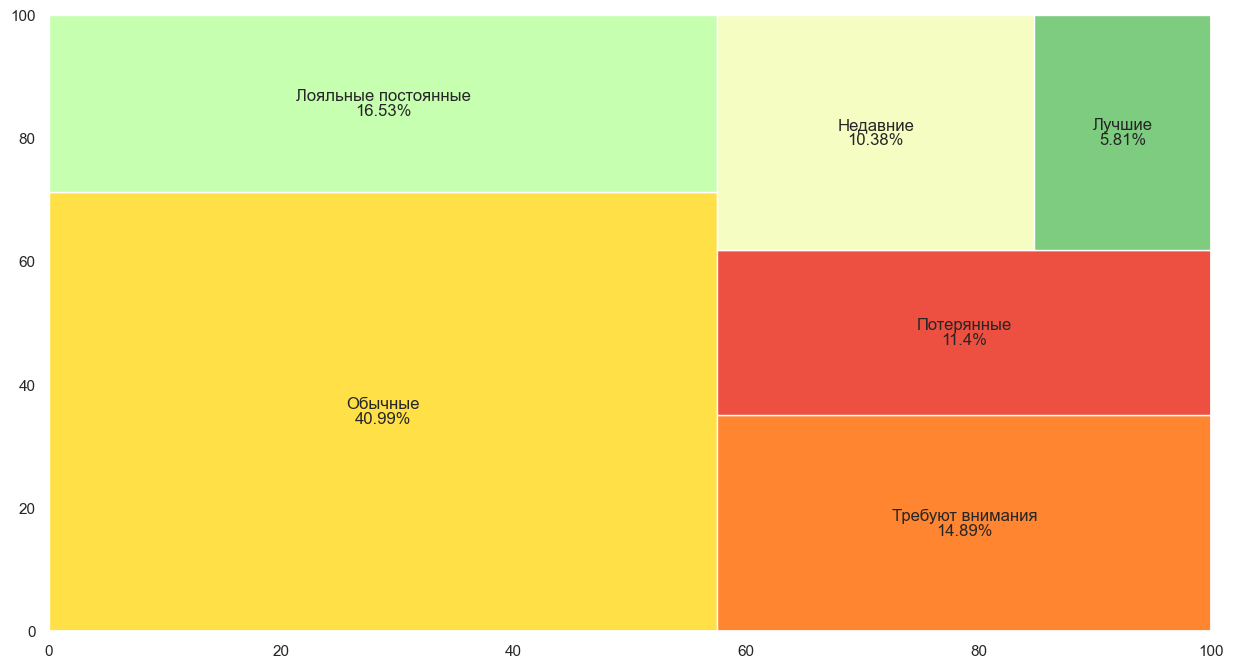

In [138]:
y = rfm['group'].value_counts() # берем необходимые для графика значения
colors = ["#ffe046",'#c5ffaf','#ff8531',"#ed5041","#F6FDC3","#7dcc7f"] # ставим подходящие цвета

sns.set(rc = {'figure.figsize':(15, 8)})
squarify.plot(sizes=y.values,label = y.index, 
              color= colors,
              value = [str(round(i/rfm.shape[0]*100,2))+'%' for i in y.values])

У нас есть довольно хороший костяк лояльной аудитории (22%) и вполне приемлемый процент "оттока" (11%)

# 5. Результаты <a class="anchor" id="5"></a>

##### Общие показатели


В ходе исследования бизнес-показателей Афиши за период с июня 2017 по конец мая 2018 года можно отметить следующее: - в основном компания работает на потребительский сектор.
Выручка и прибыль компании растут быстрыми темпами, в основном это происходит за счет увеличение клиентской базы, так как и средний чек и количество заказов на одного покупателя почти не меняются.
По выручке видна годовая сезонность, просадки наблюдаются в начале года и в середине лета, а достигают пиковых значений в июле и ближе к новому году. Это можно связать с подготовкой к праздникам и поиском отличных подарков. 
По итогам 2015 года на сайте ежемесячно совершали покупки 728 клиентов, ежемесячная прибыль составила 41653. В среднем один пользователь совершает 1.16 заказов за год

##### Retention
Процент пользователей совершавших повторые покупки упал с 50% в 2012 году до 10% в 2015. Из этого можно сделать вывод, что обычно клиент к нам возвращается раз в несколько лет. Тем не менее, за этот перод ретеншн следующего года вырос с 18% в 2012 году до 21% в 2014.

##### LTV
LTV первого года покупок остается практически неизменным на протяжении всего периода, что логично, так как срдений чек тоже не менятеся, однако LTV последующих лет постепено растет

##### RFM
По результатам RFM анализа удалось выделить следующие сегменты пользователей:
- Лучшие и лояльные пользователи (22%) - постоянные клиеты, составлющие ядро нашей аудитории.

-  Требующие внимания (15%) - пользователи, которые делали большие и частые покупки, но уже давно к нам не заходили. Их можно попробовать простимулировать рассылками, акциями, или пуш-уведовлениями.
- Потерянные (11%) - пользователи, которые покупали мало, не часто, и уже давно к нам не заходили. Пытаться вернуть скорее всего бесполезно
- Новички (10%) - клиенты, недавно совершившие первую покупку, можно пробовать взаимодействовать, чтобы повысить их шансы перехода в лояльную группу, предложить тематическую скидку, составить подборку рекомендованных товаров итд.
- Обычные (41%) - наша аудитория

#### Рекомандации
Основные показатели компании имеют довольно хорошую динамику, единственное, что стоит на месте это средний чек. Чтобы это исправить можно пробовать создать свою программу рояльности, делать специальные предложения и другие акции. Также хорошей идеей для стимулирования спроса может быть рассылка пуш уведомлений с персональными предложениями, начать можно с пользователей из группы "требуют внимания".

